In [1]:
from localization_scripts.imports import *
%load_ext autoreload
%autoreload 2

In [2]:
filename = '/home/smlm-workstation/event-smlm/our_ev_smlm_recordings/MT_5May_S2_reduced_bias_580sec/MT_5May_S2_reduced_bias_580sec.raw'
if os.path.basename(filename)[-4:] == ".raw":
    events = raw_events_to_array(filename).astype(
        [("x", "uint16"), ("y", "uint16"), ("p", "byte"), ("t", "uint64")]
    )

slice = events[(events["t"] < 150e6)]

In [3]:
from numba import njit, prange, types, typed, jit
from numba.typed import List
# from localization_scripts.event_array_processing import array_to_polarity_map
NUM_CORES = multiprocessing.cpu_count()

"""PROMINENCE is the prominence of the peaks in the convolved signals.
Smaller value detects more peaks, increasing the evaluation time."""
PROMINENCE = 18

"""DATASEET_FWHM is the FWHM of the PSF in the dataset in pixels."""
DATASEET_FWHM = 6

"""PEAK_TIME_THRESHOLD is the maximum time difference between two peaks in order to be considered as the same peak."""
PEAK_TIME_THRESHOLD = 40e3

"""PEAK_NEIGHBORS is the number of neighboring pixels to be considered when filtering same peaks."""
PEAK_NEIGHBORS = 7

"""ROI_RADIUS is the radius of the generated ROI in pixels."""
ROI_RADIUS = 8

events = slice
start_time = time.time()

# Get the minimum and maximum x and y coordinates
min_x = events["x"].min()
min_y = events["y"].min()
max_x = events["x"].max()
max_y = events["y"].max()

# Create coordinate lists
y_coords, x_coords = [min_y, max_y], [min_x, max_x]
coords = generate_coord_lists(y_coords[0], y_coords[1], x_coords[0], x_coords[1])

# Generate dictionaries and calculate max length
print(f"Analyzing the data using {NUM_CORES} cores... Events go brrrrrrrrrrrr!")
print(
    f"Converting events to dictionaries... Elapsed time: {time.time() - start_time:.2f} seconds"
)

@njit(cache=True, nogil=True, fastmath=True)
def array_to_polarity_map2(arr, coords):
    """
    Converts a structured NumPy ndarray with fields x, y, p, t into a dictionary with keys as (x, y) pairs and
    values as a nested dictionary with keys from p and corresponding values from t as a list for that coordinate pair.
    """
    dict_out = {}
    time_map = {}
    max_len = 0
    for id in prange(len(arr)):
        key = (arr[id]["y"], arr[id]["x"])
        if key in dict_out:
            dict_out[key][arr[id]["p"]].append(arr[id]["t"])
        else:
            dict_out[key] = {
                0: List.empty_list(types.uint64),
                1: List.empty_list(types.uint64),
                2: List.empty_list(types.uint64),
                3: List.empty_list(types.uint64),
                4: List.empty_list(types.uint64)
            }
            dict_out[key][arr[id]["p"]].append(arr[id]["t"])
        if key in time_map:
            time_map[key][arr[id]["t"]] = arr[id]["p"]
        else:
            time_map[key] = {arr[id]["t"]: arr[id]["p"]}
        if len(dict_out[key][1]) > max_len:
            max_len = len(dict_out[key][1])
        if len(dict_out[key][0]) > max_len:
            max_len = len(dict_out[key][0])
    for key in dict_out.keys():
        dict_out[key][2].append(len(dict_out[key][0]) + len(dict_out[key][1]))
        dict_out[key][3].append(len(dict_out[key][0]))
        dict_out[key][4].append(len(dict_out[key][1]))
    return dict_out, time_map, max_len

dict_events, time_map, max_len = array_to_polarity_map2(events, coords)

Analyzing the data using 24 cores... Events go brrrrrrrrrrrr!
Converting events to dictionaries... Elapsed time: 0.16 seconds


In [9]:
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
@njit(cache=True, nogil=True, fastmath=True)
def remove_coordinates(arr, my_dict):
    for y in range(arr.shape[0]):
        for x in range(arr.shape[1]):
            if arr[y, x] == 0:
                coord = (y, x)
                if coord in my_dict:
                    del my_dict[coord]
    return my_dict

@njit(cache=True, nogil=True, fastmath=True)
def fill_widefield(dict_events):
    widefield = np.zeros((max_y+1, max_x+1), dtype=np.uint64)
    for key in dict_events.keys():
        widefield[key[0], key[1]] = dict_events[key][2][0]
    return widefield

def remove_background(dict_events, filename, sigma=9.5, radius=9):
    widefield_filtered = gaussian_filter(fill_widefield(dict_events), sigma=sigma, radius=radius)
    useful_pixels = np.where(widefield_filtered >= np.percentile(widefield_filtered, 50), widefield, 0)
    plt.imsave(filename[:-4]+"useful_pixels.png", dpi=300, arr=useful_pixels, cmap="gray", vmax=150)
    filtered_dict = remove_coordinates(useful_pixels, dict_events)
    return filtered_dict

filtered_dict = remove_background(dict_events, filename)

In [142]:
filtered_dict[(500,500)]

DictType[int64,ListType[uint64]]<iv=None>({0: [1438662, 3377340, 9795706, 11021065, 13427214, 14708733, 15896863, 18095999, 19455349, 25746023, 26309206, 27718872, 29454409, 36408672, 39060495, 39878212, 45828800, 52999289, 53982259, 58438118, 59267433, 63620674, 64520388, 67154215, 68188310, 69108233, 71309819, 72032191, 73935379, 76231102, 83370368, 86708422, 86808255, 91052370, 95183526, 96147269, 98000763, 98057719, 98307135, 103700811, 105199107, 107286937, 109524775, 109609282, 114506809, 118322001, 119574995, 124747136, 128374071, 130701707, 135955075, 137268716, 138354837, 139245758, 144750023, 147147643, 149820222, ...], 1: [1048751, 1699065, 3648401, 3818160, 9887397, 10401016, 11077617, 12966116, 13640548, 14532814, 14795105, 15185717, 16171621, 17934033, 18645843, 19279371, 19297170, 25843377, 26036843, 26565415, 27247332, 27290288, 29122577, 29595974, 35281805, 36607378, 38521866, 39682031, 39782342, 40044652, 45494795, 47165086, 53093829, 53810618, 53846889, 56142777, 586

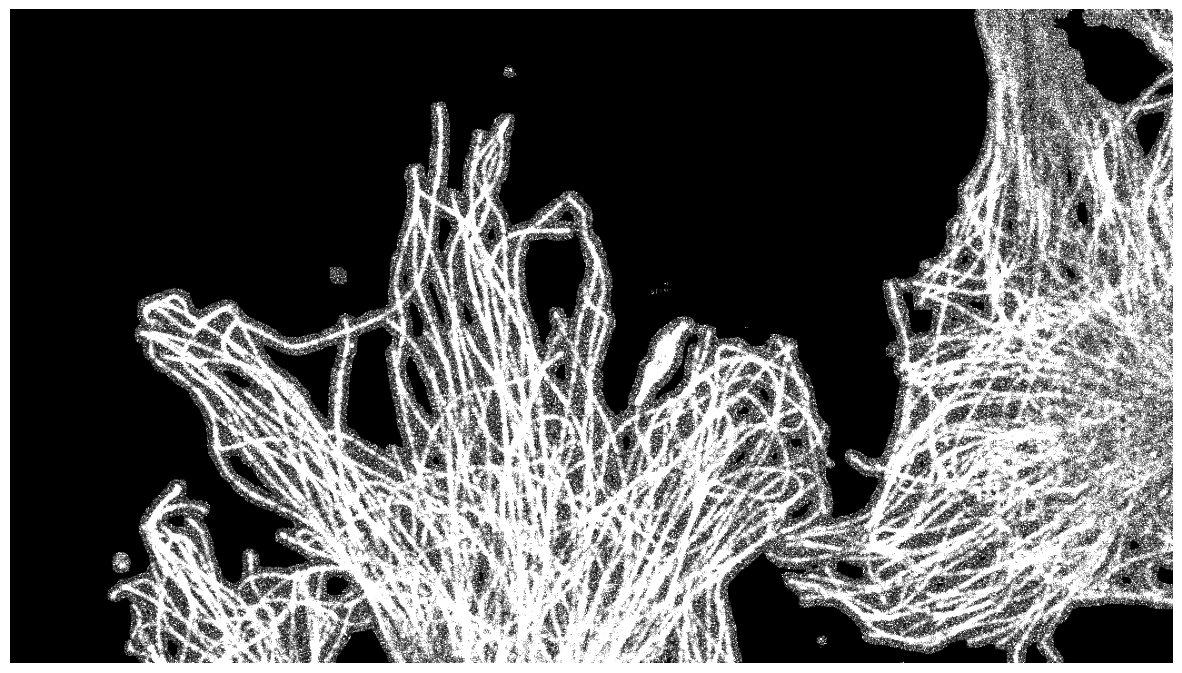

In [143]:
from scipy.ndimage import gaussian_filter


plt.figure(figsize=(15, 10))
plt.axis("off")
widefield_filtered = gaussian_filter(widefield, sigma=9.5, radius=9)
useful_pixels = np.where(widefield_filtered >= np.percentile(widefield_filtered, 60), widefield, 0)

# plt.imshow(gaussian_filter(widefield), sigma=0.8, radius=5), cmap="gray", vmax=30)
plt.imshow(np.where(widefield_filtered >= np.percentile(widefield_filtered, 50), widefield, 0), cmap="gray", vmax=100)

In [53]:
import numpy as np

def find_top_1_percent_values(arr):
    flat_arr = arr.flatten()  # Flatten the 2D array to a 1D array
    cutoff = np.percentile(flat_arr, 99.99)  # Calculate the cutoff value for the top 1%
    
    coordinates = np.argwhere(arr >= cutoff)  # Get the coordinates where values are greater than or equal to the cutoff
    values = arr[coordinates[:, 0], coordinates[:, 1]]  # Get the corresponding values
    
    result = {tuple(coord): value for coord, value in zip(coordinates, values)}  # Create a dictionary with coordinates as keys and values as values
    return result

result = find_top_1_percent_values(widefield)
print(result)

{(34, 1018): 147, (52, 167): 129, (67, 551): 250, (211, 127): 101, (213, 1220): 140, (226, 449): 120, (238, 979): 105, (239, 673): 102, (253, 507): 169, (266, 658): 96, (267, 1084): 123, (279, 783): 97, (293, 361): 683, (321, 188): 107, (321, 523): 123, (331, 555): 98, (353, 527): 103, (353, 528): 96, (355, 733): 99, (363, 506): 115, (368, 728): 98, (374, 973): 285, (375, 715): 119, (384, 240): 124, (385, 727): 107, (386, 213): 121, (396, 584): 102, (401, 1255): 150, (405, 292): 104, (406, 765): 98, (407, 643): 1199, (409, 542): 99, (416, 599): 99, (419, 699): 129, (420, 697): 151, (423, 697): 114, (429, 694): 133, (435, 1075): 167, (449, 360): 186, (449, 686): 205, (461, 983): 172, (466, 608): 125, (505, 318): 143, (517, 381): 103, (517, 547): 101, (519, 773): 97, (519, 774): 102, (521, 773): 96, (521, 774): 99, (524, 546): 137, (528, 1154): 163, (545, 757): 120, (547, 757): 102, (551, 814): 349, (553, 755): 107, (554, 754): 105, (559, 950): 96, (561, 392): 105, (561, 749): 104, (561,